# Text Analytics - Assignment 4

Grammatikopoulou Maria - f3352310

Phevos A. Margonis - f3352317

Moniaki Melina - f3352321

#### Exercise 2

In [3]:
# NLP Parsing and Processing - Uncomment if using these libraries
# !pip install conllu
# !pip install halo
# !pip install pydot
# !pip install fasttext-wheel
# !pip install tensorflow[and-cuda] # For linux & GPU support
# import gensim.downloader as api
import datetime
import os
import re
import time
import warnings
from collections import Counter
import fasttext
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
# from catalogue import create
from conllu import parse_incr
from halo import Halo
from keras.utils import to_categorical
from numpy.random import default_rng
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, auc, classification_report,
                             f1_score, precision_recall_curve, precision_score,
                             recall_score)
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from tensorflow.keras.callbacks import (EarlyStopping, ModelCheckpoint,
                                        TensorBoard)
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm

rng = default_rng(587)

## Parse the CONLLU files

In [101]:

# from sklearn.metrics.classification import _DEFAULT_ZERO_DIVISION
# # Set the default value for zero_division globally
# _DEFAULT_ZERO_DIVISION = 0

# # %% Parsing
# # ======= UNCOMMENT TO READ RAW CONLLU FILES =========================================
# # %% Parse conllu files
# def read_conllu(data_file_path: str) -> list[list[str], list[str]]:
#     """ Input path to file.
#         Return for each text its [tokens, upos]

#         Ta dataset exoun kapoia discrepancies vasi tou splitting convention pou akolouthoun.
#         Den iparxeei POS Tag '_' ara afairoume oles tis grammes pou exoun tetoio 'target'
#     """

#     docs = []
#     # Open the file and parse it
#     with open(data_file_path, 'r', encoding='utf-8') as file:
#         for tokenlist in tqdm(parse_incr(file), desc="Parsing", unit=" tokenlists"):
#             text, pos = [], []
#             for i in range(len(tokenlist)):
#                 token = tokenlist[i]
#                 if token['upos'] != '_':  # Important data cleaning trick
#                     text.append(token['form'])
#                     pos.append(token['upos'])

#             docs.append([text, pos])
#     return docs


# # Read data files
# train_data_raw = read_conllu('UD_English-GUM-master/en_gum-ud-train.conllu')
# val_data_raw = read_conllu('UD_English-GUM-master/en_gum-ud-dev.conllu')
# test_data_raw = read_conllu('UD_English-GUM-master/en_gum-ud-test.conllu')

# # %% Post-process raw-data
# def create_input_output_data(raw_data: list[list, list]) -> pd.DataFrame:
#     '''
#     Post process the raw data as X and y, to pass to Tensorflow.

#     Parameters
#     ----------
#     raw_data : list[list, list]
#         A list where each row has 2 lists.
#         List[0] are the sentences.
#         List[1] are the upos tags.

#     Returns
#     -------
#     df : pd.Dataframe{string,string}
#         Dataframe with columns X, y.

#     '''
#     X = [" ".join(tokenlist[0]) for tokenlist in raw_data]
#     y = [" ".join(tokenlist[1]) for tokenlist in raw_data]
#     df = pd.DataFrame({
#         'text': X,
#         'labels': y
#     })
#     return df


# # Convertion
# trainDF = create_input_output_data(train_data_raw)
# valDF = create_input_output_data(val_data_raw)
# testDF = create_input_output_data(test_data_raw)

# # %% Store processed data
# trainDF.to_csv('en_gum_train.csv', index=False)
# valDF.to_csv('en_gum_val.csv', index=False)
# testDF.to_csv('en_gum_test.csv', index=False)

## Data Exploration

In [4]:
trainDF = pd.read_csv('en_gum_train.csv').drop_duplicates().reset_index(drop=True)
valDF = pd.read_csv('en_gum_val.csv')
testDF = pd.read_csv('en_gum_test.csv')

In [5]:
trainDF.info()

trainDF.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8165 entries, 0 to 8164
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    8165 non-null   object
 1   labels  8165 non-null   object
dtypes: object(2)
memory usage: 127.7+ KB


,text,labels
count,8165,8165
unique,8160,7331
top,Sure .,INTJ PUNCT
freq,3,61


In [6]:
trainDF.head()

,text,labels
0,Aesthetic Appreciation and Spanish Art :,ADJ NOUN CCONJ ADJ NOUN PUNCT
1,Insights from Eye - Tracking,NOUN ADP NOUN PUNCT NOUN
2,Claire Bailey - Ross claire.bailey-ross@port.a...,PROPN PROPN PUNCT PROPN PROPN PROPN ADP PROPN ...
3,Andrew Beresford a.m.beresford@durham.ac.uk Du...,PROPN PROPN PROPN PROPN PROPN PUNCT VERB PROPN
4,Daniel Smith daniel.smith2@durham.ac.uk Durham...,PROPN PROPN PROPN PROPN PROPN PUNCT VERB PROPN


In [7]:
print(pd.Series([len(text.split()) for text in trainDF.text]).describe())
percentile = 90
print(f"{percentile}th Percentile length of train sentences: {np.percentile([len(text.split()) for text in trainDF.text],percentile)}")

count    8165.000000
mean       18.003552
std        13.221574
min         1.000000
25%         8.000000
50%        15.000000
75%        25.000000
max       110.000000
dtype: float64
90th Percentile length of train sentences: 35.0


In [8]:
print(trainDF.text[0])
print(trainDF.labels[0])

Aesthetic Appreciation and Spanish Art :
ADJ NOUN CCONJ ADJ NOUN PUNCT


In [9]:
TARGET_NAMES = sorted(list(set(' '.join(trainDF.labels).split())))
NCLASSES = len(TARGET_NAMES)
print('Target Names:',TARGET_NAMES)

Target Names: ['ADJ', 'ADP', 'ADV', 'AUX', 'CCONJ', 'DET', 'INTJ', 'NOUN', 'NUM', 'PART', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'SYM', 'VERB', 'X']


## Majority Classifier
A baseline that tags each word with the most frequent tag it had in the training data. Words that were not encountered in the training data, the baseline will return the most frequent tag (over all words) of the training data.

In [10]:

def flatten_and_encode(df) -> pd.DataFrame:
    '''Flatten each text sentence and each label. Then Encode the labels as category ints'''
    df_flattened        = df['text'].str.lower().str.split(expand=True).stack().reset_index(drop=True).to_frame(name='word') # Flatten train data
    df_flattened['tag'] = df['labels'].str.lower().str.split(expand=True).stack().reset_index(drop=True)
    df_flattened['tag'] = df_flattened['tag'].astype('category').cat.codes # Encode 'tag'
    return df_flattened

# Majority Dummy classifier: Find the most common label for each unique word using the Train-set
train_flattened  = flatten_and_encode(trainDF)
trainMajorityTag = train_flattened.groupby('word')['tag'].agg(lambda x: x.mode()[0]).to_frame() # Find the most common tag for each word
trainMajorityTag = trainMajorityTag.tag.to_dict() # dict{word: most_commont_tag}

# Flatten evaluation datasets
val_flattened  = flatten_and_encode(valDF)
test_flattened = flatten_and_encode(testDF)

# Get y_true for each dataset
y_train_true = train_flattened.tag.tolist()
y_val_true   = val_flattened.tag.tolist()
y_test_true  = test_flattened.tag.tolist()

# Find the overall most common tag inside train-set
most_common_tag = train_flattened.tag.mode()[0]

# Create the prediction using Majority dummy classifier
y_train_pred = [trainMajorityTag.get(word,most_common_tag) for word in train_flattened.word]
y_val_pred   = [trainMajorityTag.get(word,most_common_tag) for word in val_flattened.word]
y_test_pred  = [trainMajorityTag.get(word,most_common_tag) for word in test_flattened.word]

majority_val_acc = accuracy_score(y_val_true, y_val_pred).round(2)

print(classification_report(y_train_true, y_train_pred, target_names=TARGET_NAMES))
print(classification_report(y_val_true, y_val_pred, target_names=TARGET_NAMES))
print(classification_report(y_test_true, y_test_pred, target_names=TARGET_NAMES))

              precision    recall  f1-score   support

         ADJ       0.91      0.93      0.92      9761
         ADP       0.90      0.89      0.90     14045
         ADV       0.89      0.85      0.87      6969
         AUX       0.87      0.95      0.91      7689
       CCONJ       0.99      1.00      0.99      4846
         DET       0.95      0.98      0.96     12066
        INTJ       0.73      0.76      0.74      1144
        NOUN       0.92      0.95      0.93     24618
         NUM       0.95      1.00      0.98      2924
        PART       0.69      0.90      0.78      3466
        PRON       0.92      0.96      0.94     12059
       PROPN       0.94      0.82      0.88      8934
       PUNCT       0.99      1.00      1.00     20274
       SCONJ       0.85      0.33      0.48      2324
         SYM       0.95      0.68      0.79       231
        VERB       0.93      0.89      0.91     15347
           X       0.97      0.73      0.84       302

    accuracy              

## Prepare X, y

In [11]:
MAX_WORDS = 100000
MAX_SEQUENCE_LENGTH = 32
EMBEDDING_DIM = 300

# Vectorize y
vectorize_Y = layers.TextVectorization(max_tokens=MAX_WORDS,
                                output_mode='int',
                                standardize=None,
                                ngrams=1,
                                vocabulary=TARGET_NAMES,
                                output_sequence_length=MAX_SEQUENCE_LENGTH)

y_train_sequential = vectorize_Y(trainDF.labels.values).numpy()
y_val_sequential = vectorize_Y(valDF.labels.values).numpy()
y_test_sequential = vectorize_Y(testDF.labels.values).numpy()

TARGET_NAMES = vectorize_Y.get_vocabulary()

In [12]:
print(f"{' New Target Names ':=^80}")
print(vectorize_Y.get_vocabulary(), '\n')
print('-First sentence target names:',trainDF.labels[0])
print('-First sentence targets encoded:',y_train_sequential[0])
print(f"{' An other sample ':=^80}")
print(valDF.labels[1])
print(y_val_sequential[1])

=============================== New Target Names ===============================
['', '[UNK]', 'ADJ', 'ADP', 'ADV', 'AUX', 'CCONJ', 'DET', 'INTJ', 'NOUN', 'NUM', 'PART', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'SYM', 'VERB', 'X'] 

-First sentence target names: ADJ NOUN CCONJ ADJ NOUN PUNCT
-First sentence targets encoded: [ 2  9  6  2  9 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
=============================== An other sample ================================
NOUN ADP NOUN PUNCT VERB ADJ NOUN PUNCT NOUN PUNCT AUX VERB ADJ NOUN ADP DET ADJ NOUN VERB DET NOUN CCONJ NOUN ADP NOUN NOUN PUNCT NUM PUNCT SYM PUNCT NUM PUNCT PUNCT
[ 9  3  9 14 17  2  9 14  9 14  5 17  2  9  3  7  2  9 17  7  9  6  9  3
  9  9 14 10 14 16 14 10]


In [13]:
# Initialize X vectorizer
vectorizer = layers.TextVectorization(max_tokens=MAX_WORDS,
                               output_mode='int',
                               standardize="lower",
                               ngrams=1,
                               output_sequence_length=MAX_SEQUENCE_LENGTH)

vectorizer.adapt(trainDF.text)

MAX_WORDS = vectorizer.vocabulary_size()
print(f"Vocabulary size: { MAX_WORDS } words.")

Vocabulary size: 14388 words.


In [14]:
# Gold
print(f"{' Sentences ':=^80}")
print(trainDF.text[0:2])
# Vectorized
print(f"{' Vectorized Representations ':=^80}")
print(vectorizer.call(trainDF.text[0:2]))
# Reconstruction
sentences = vectorizer.call(trainDF.text[0:2])
vocabulary = vectorizer.get_vocabulary()
words = [vocabulary[idx] for sentence in sentences for idx in sentence]
print(f"{' Reconstructed from vectorizer ':=^80}")
print(words)

================================== Sentences ===================================
0    Aesthetic Appreciation and Spanish Art :
1                Insights from Eye - Tracking
Name: text, dtype: object
========================== Vectorized Representations ==========================
tf.Tensor(
[[1343 2367    5  629  286   60    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]
 [3023   30  992   20 1502    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]], shape=(2, 32), dtype=int64)
======================== Reconstructed from vectorizer =========================
['aesthetic', 'appreciation', 'and', 'spanish', 'art', ':', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 'insights', 'from', 'eye', '-', 'tracking', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 

## Embedding Matrix

In [15]:
if os.path.exists('embedding_matrix.npz'):
    embedding_matrix = np.load('embedding_matrix.npz')['embeddings']
    print('Embeddings matrix found.')
else:
    print('Loading Fasttext model...')
    fasttext_model = fasttext.load_model('cc.en.300.bin')
    print("Process completed!")

    embedding_matrix = np.zeros(shape=(MAX_WORDS, 300))

    for w2idx, _word in tqdm(enumerate(vectorizer.get_vocabulary()), total=MAX_WORDS, desc='Embedding matrix creation'):
        # Skip PAD and UNK tokens
        if w2idx >= 2:
            embedding_matrix[w2idx] = fasttext_model.get_word_vector(_word)

    del fasttext_model

    np.savez('embedding_matrix.npz', embeddings=embedding_matrix)
    print('Embeddings matrix stored for future reference.')

Embeddings matrix found.


## Recurrent Neural Network

In [114]:
class Metrics(tf.keras.callbacks.Callback):
    def __init__(self, valid_data):
        super(Metrics, self).__init__()
        self.validation_data = valid_data

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_predict = np.argmax(self.model.predict(self.validation_data[0]), -1)
        val_targ = self.validation_data[1]
        val_targ = tf.cast(val_targ, dtype=tf.float32)
        if len(val_targ.shape) == 2 and val_targ.shape[1] != 1:
            val_targ = np.argmax(val_targ, -1)

        _val_f1 = f1_score(val_targ, val_predict, average="weighted", zero_division=1)
        _val_recall = recall_score(val_targ, val_predict, average="weighted", zero_division=1)
        _val_precision = precision_score(val_targ, val_predict, average="weighted", zero_division=1)

        logs['val_f1'] = _val_f1
        logs['val_recall'] = _val_recall
        logs['val_precision'] = _val_precision
        print(" — val_f1: %f — val_precision: %f — val_recall: %f" % (_val_f1, _val_precision, _val_recall))
        return

### Embedding Layer
In contrast to RNN layers the mask is not passed correctly to the `.evaluate()`, but is able to correcly mask 'pad' tokens in `.predict()

In [116]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

FILTERS = 128  # Dimention of each h
DENSE = 256

# # TENSORBOARD: Create a log directory with a timestamp to create a unique directory for each run
# log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=0)

# Functional API
text = layers.Input(shape=(1,), dtype=tf.string, name="input_text")
vectorized = vectorizer(text)
word_embeddings = layers.Embedding(MAX_WORDS, EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            mask_zero=True, 
                            trainable=False)(vectorized)
word_embeddings = layers.Dropout(0.33)(word_embeddings)
# CNN
pooled_convs = []
filter_sizes = [2, 3, 4]

for n_gram in filter_sizes:
    # Seed layer
    convs = layers.Conv1D( filters=FILTERS, kernel_size=n_gram, strides=1, padding="same", use_bias=False, name=f"{n_gram}-gram_Convolutions1",)(word_embeddings)

    # Block 1
    residual = convs
    convs = layers.BatchNormalization()(convs)
    convs = layers.Activation("relu")(convs)
    convs = layers.Conv1D(filters=FILTERS, kernel_size=n_gram, strides=1, padding="same", use_bias=False, name=f"{n_gram}-gram_Convolutions2",)(convs)
    convs = layers.BatchNormalization()(convs)
    convs = layers.Activation("relu")(convs)
    convs = layers.Conv1D(filters=FILTERS, kernel_size=n_gram, strides=1, padding="same", use_bias=False, name=f"{n_gram}-gram_Convolutions3",)(convs)
    convs = layers.Add()([convs, residual])

    # Block 2
    residual = convs
    convs = layers.BatchNormalization()(convs)
    convs = layers.Activation("relu")(convs)
    convs = layers.Dropout(0.3)(convs)
    convs = layers.Conv1D(filters=FILTERS, kernel_size=n_gram, strides=1, padding="same", use_bias=False, name=f"{n_gram}-gram_Convolutions4",)(convs)
    convs = layers.BatchNormalization()(convs)
    convs = layers.Activation("relu")(convs)
    convs = layers.Conv1D(filters=FILTERS, kernel_size=n_gram, strides=1, padding="same", use_bias=False, name=f"{n_gram}-gram_Convolutions5",)(convs)
    convs = layers.Add()([convs, residual])

    # Block 3
    residual = convs
    convs = layers.BatchNormalization()(convs)
    convs = layers.Activation("relu")(convs)
    convs = layers.Dropout(0.3)(convs)
    convs = layers.Conv1D(filters=FILTERS, kernel_size=n_gram, strides=1, padding="same", use_bias=False, name=f"{n_gram}-gram_Convolutions6",)(convs)
    convs = layers.BatchNormalization()(convs)
    convs = layers.Activation("relu")(convs)
    convs = layers.Conv1D(filters=FILTERS, kernel_size=n_gram, strides=1, padding="same", use_bias=False, name=f"{n_gram}-gram_Convolutions7",)(convs)
    convs = layers.Add()([convs, residual])

    # Pool n-gram embeddings
    pooled_convs.append(convs)

# MLP
concat   = layers.Concatenate()(pooled_convs)
rich_features = layers.Dense(units=DENSE, activation='relu')(concat)
rich_features = layers.Dropout(0.4)(rich_features)
rich_features = layers.Dense(units=DENSE, activation='tanh')(rich_features)
rich_features = layers.Dropout(0.1)(rich_features)
# Classification
pos_tags = layers.Dense(NCLASSES+2, activation='softmax', name="output")(rich_features) # +2 due to vectorizer_Y # oxi =2
# Instantiate
model = tf.keras.Model(inputs=text, outputs=pos_tags)

print(model.summary())

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=Adam(learning_rate=0.001),
    metrics=["accuracy"],
)

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,
                               restore_best_weights=True)

start_training_time = time.time()

history = model.fit(
    np.array(trainDF.text), y_train_sequential,
    validation_data=(np.array(valDF.text), y_val_sequential),
    batch_size=256,
    epochs=150,
    shuffle=True,
    callbacks=[early_stopping]) #, tensorboard_callback])

end_training_time = time.time()

print(f'\nTraining time: {time.strftime("%H:%M:%S", time.gmtime(end_training_time - start_training_time))} \n')

# Same the complete model once
model.save('checkpoints/model_ex2_masked')

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_text (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 text_vectorization_7 (Text  (None, 32)                   0         ['input_text[0][0]']          
 Vectorization)                                                                                   
                                                                                                  
 embedding_13 (Embedding)    (None, 32, 300)              4316400   ['text_vectorization_7[1][0]']
                                                                                                  
 dropout_125 (Dropout)       (None, 32, 300)              0         ['embedding_13[0][0]'] 

INFO:tensorflow:Assets written to: checkpoints/model_ex2_masked/assets


In [117]:
loss, accuracy = model.evaluate(np.array(trainDF.text), y_train_sequential, verbose=1)
print(f"Loss: {loss:.4f}\nAccuracy: {accuracy*100:.4f}%")

256/256 [==============================] - 8s 31ms/step - loss: 0.0380 - accuracy: 0.9877
Loss: 0.0380
Accuracy: 98.7688%


In [118]:
loss, accuracy = model.evaluate(np.array(valDF.text), y_val_sequential, verbose=1)
print(f"Loss: {loss:.4f}\nAccuracy: {accuracy*100:.4f}%") # GRU .9366

35/35 [==============================] - 1s 30ms/step - loss: 0.1332 - accuracy: 0.9628
Loss: 0.1332
Accuracy: 96.2763%


In [119]:
loss, accuracy = model.evaluate(np.array(testDF.text), y_test_sequential, verbose=1)
print(f"Loss: {loss:.4f}\nAccuracy: {accuracy*100:.4f}%")

35/35 [==============================] - 1s 32ms/step - loss: 0.1724 - accuracy: 0.9516
Loss: 0.1724
Accuracy: 95.1642%


In [16]:
model = load_model('checkpoints/model_ex2_masked') # or model_ex2_masked_masked

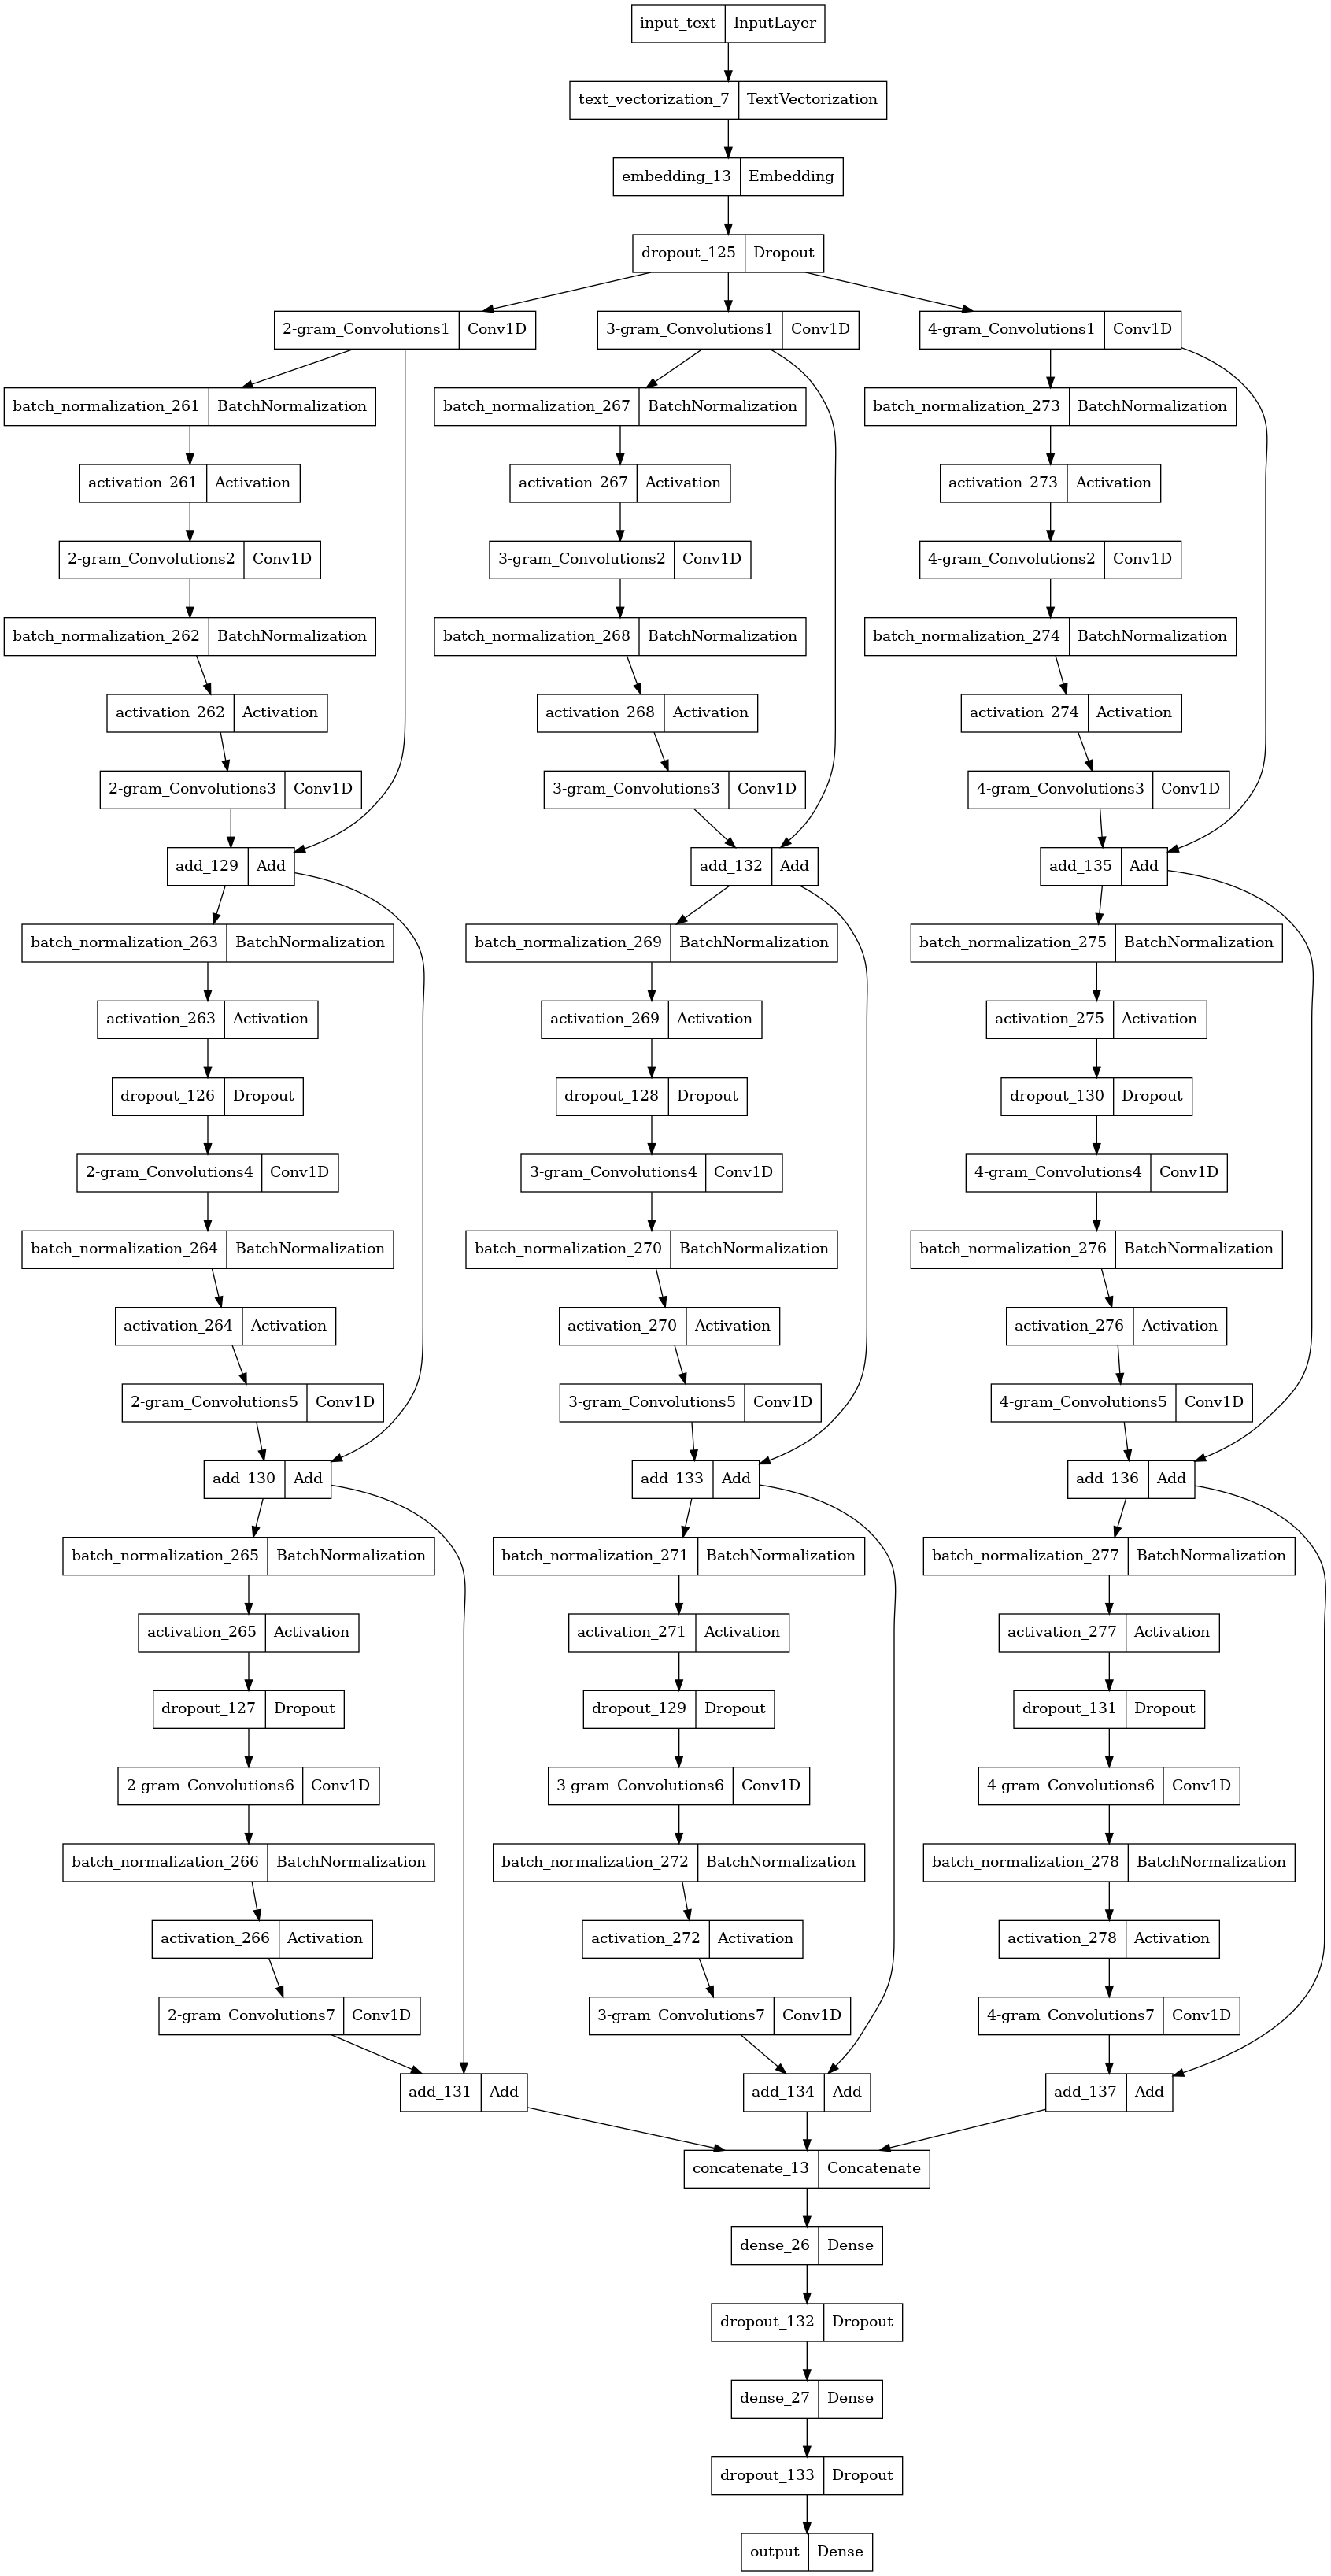

In [121]:
tf.keras.utils.plot_model(model,"POS_tagging_model.png")

In [122]:
# !tensorboard --logdir=logs/fit
# '''
# http://localhost:6006/
# '''

In [17]:
mask_train = (y_train_sequential.flatten() != 0)
predictions = np.argmax(model.predict(trainDF.text), -1)
print(classification_report(y_train_sequential.flatten()[mask_train],  # (sentence, labels) -> (all_labels)
                            predictions.flatten()[mask_train],
                            labels=list(range(2,19)),
                            target_names=TARGET_NAMES[2:]
                            ))

mask_val = (y_val_sequential.flatten() != 0)
predictions = np.argmax(model.predict(valDF.text), -1)
print(classification_report(y_val_sequential.flatten()[mask_val], 
                            predictions.flatten()[mask_val],
                            labels=list(range(2,19)),
                            target_names=TARGET_NAMES[2:]
                            ))

validation_accuracy = accuracy_score(
    y_val_sequential.flatten()[y_val_sequential.flatten() != 0],
    predictions.flatten()[y_val_sequential.flatten() != 0]
)

mask_test = (y_test_sequential.flatten() != 0)
predictions = np.argmax(model.predict(testDF.text), -1)
print(classification_report(y_test_sequential.flatten()[mask_test], 
                            predictions.flatten()[mask_test],
                            labels=list(range(2,19)),
                            target_names=TARGET_NAMES[2:]
                            ))

print(validation_accuracy)

256/256 [==============================] - 10s 35ms/step
              precision    recall  f1-score   support

         ADJ       0.94      0.96      0.95      8907
         ADP       0.98      0.98      0.98     12922
         ADV       0.94      0.96      0.95      6508
         AUX       0.99      0.99      0.99      7266
       CCONJ       1.00      1.00      1.00      4356
         DET       0.99      1.00      1.00     11187
        INTJ       0.98      0.91      0.94      1118
        NOUN       0.97      0.97      0.97     22484
         NUM       0.99      0.99      0.99      2567
        PART       0.99      0.99      0.99      3253
        PRON       1.00      0.99      0.99     11447
       PROPN       0.92      0.93      0.92      8116
       PUNCT       1.00      1.00      1.00     17766
       SCONJ       0.90      0.92      0.91      2183
         SYM       0.96      0.96      0.96       211
        VERB       0.98      0.97      0.98     14428
           X       1.00 

In [19]:
# Predict class probabilities to be used for PR-AUC
def my_padded_multiclass_auc_report( y_true, y_pred, title: str, TARGET_NAMES=TARGET_NAMES) -> None:
    """
    Calculate the Precision-Recall AUC for each class, and then their Macro-averaged score.
    The classes are padded with '', and [UNK] classes because they have beed created with 
    TextVectorizer() layer.

    Parameters
    ----------
    y_true : np.array of int
        The one-hot label vectors for each data-point.
    y_pred : np.array of float
        The MxN predicted probabilities for each data-point (M) and class (N).
    title : str
        The title of the data-set that is processed. E.g.: Train/Val/Test.

    Returns
    -------
    None

    """
    print(f"=== PR-AUC for {title} ===")
    macro_auc = []
    for i in range(2,len(TARGET_NAMES)):
        precision, recall, _ = precision_recall_curve(y_true[:, i], y_pred[:, i])
        area = auc(recall, precision)
        print(f"PR-AUC for class {TARGET_NAMES[i]}: {area*100:.2f}%")
        macro_auc.append(area)

    print(f"-> Macro-averaged PR-AUC: {np.mean(macro_auc)*100:.2f}%\n")

In [20]:
# Suppress specific warnings temporarily
warnings.filterwarnings("ignore", message="No positive class found in y_true")

# Predict probas.
# Reshape 3D to 2D (samples, max_sequence, classes) -> (tokens,classes). Then apply mask.
predictions_train = model.predict(trainDF.text)
predictions_train = predictions_train.reshape(-1, predictions_train.shape[-1])[mask_train]
predictions_val   = model.predict(valDF.text)
predictions_val   = predictions_val.reshape(-1, predictions_val.shape[-1])[mask_val]
predictions_test  = model.predict(testDF.text)
predictions_test  = predictions_test.reshape(-1, predictions_test.shape[-1])[mask_test]

# PR-AUC report
my_padded_multiclass_auc_report(to_categorical(y_train_sequential.flatten()[mask_train]), predictions_train, 'Train')
my_padded_multiclass_auc_report(to_categorical(y_val_sequential.flatten()[mask_val]), predictions_val, 'Validation')
my_padded_multiclass_auc_report(to_categorical(y_test_sequential.flatten()[mask_test]), predictions_test, 'Test')

35/35 [==============================] - 1s 32ms/step
=== PR-AUC for Train ===
PR-AUC for class ADJ: 98.63%
PR-AUC for class ADP: 99.83%
PR-AUC for class ADV: 99.09%
PR-AUC for class AUX: 99.94%
PR-AUC for class CCONJ: 99.99%
PR-AUC for class DET: 99.97%
PR-AUC for class INTJ: 98.75%
PR-AUC for class NOUN: 99.45%
PR-AUC for class NUM: 99.91%
PR-AUC for class PART: 99.92%
PR-AUC for class PRON: 99.97%
PR-AUC for class PROPN: 97.74%
PR-AUC for class PUNCT: 100.00%
PR-AUC for class SCONJ: 97.13%
PR-AUC for class SYM: 99.02%
PR-AUC for class VERB: 99.68%
PR-AUC for class X: 81.32%
-> Macro-averaged PR-AUC: 98.25%

=== PR-AUC for Validation ===
PR-AUC for class ADJ: 92.76%
PR-AUC for class ADP: 99.11%
PR-AUC for class ADV: 93.60%
PR-AUC for class AUX: 99.70%
PR-AUC for class CCONJ: 99.84%
PR-AUC for class DET: 99.88%
PR-AUC for class INTJ: 93.52%
PR-AUC for class NOUN: 96.14%
PR-AUC for class NUM: 91.93%
PR-AUC for class PART: 99.16%
PR-AUC for class PRON: 99.74%
PR-AUC for class PROPN: 76.

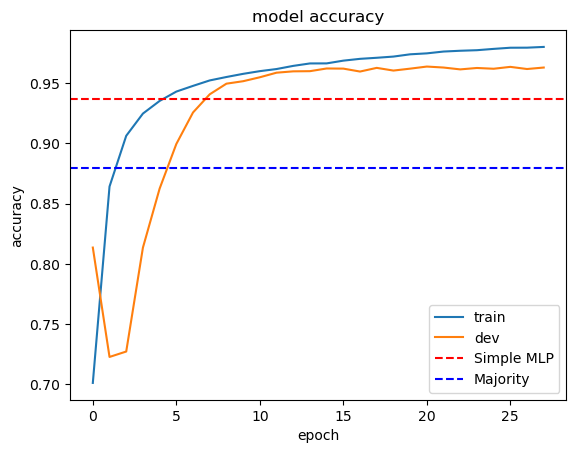

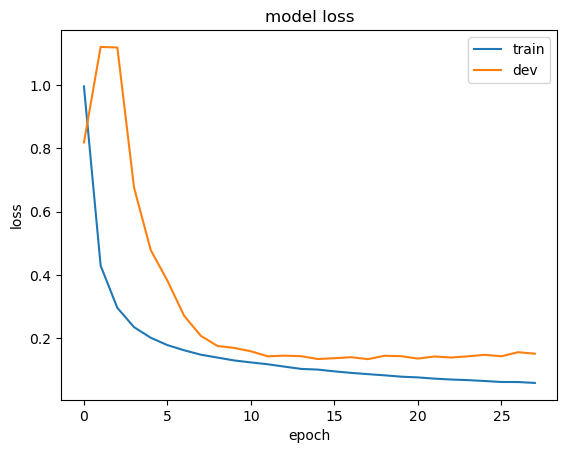

In [126]:
# history: Returned by the fit. Keeps the metrics for each epoch
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.axhline(y=0.9365, color='red', linestyle='--', label='Simple MLP')
plt.axhline(y=majority_val_acc, color='blue', linestyle='--', label='Majority')
plt.legend(['train', 'dev', 'Simple MLP', 'Majority'], loc='lower right')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper right')
plt.show()